# Task 3
# Sentiment Analysis

Nixon Andika / 13517059  
Ferdy Santoso / 13517116  
Jan Meyer Saragih / 13517131

# Data Source
https://github.com/mulhod/steam_reviews

# Task Description
Sentiment analysis merupakan sebuah task untuk menentukan sebuah teks yang bersifat subjektif (karena merupakan pendapat dari seseorang). Sentiment dari seseorang dapat bernilai positif, negatif, atau netral.  
Pada sentiment analysis di task ini, nilai sentiment dari seseorang hanya bernilai 2, yaitu positif atau negatif. Dataset berisi review dari **Steam** mengenai sebuah game dan nilai targetnya merupakan apakah game tersebut *recommended* atau *not recommended*. Akurasi yang dihitung merupakan berapa dari review steam tersebut yang diprediksi benar.

# Latar Belakang
Game **Steam** sudah memiliki banyak review dari setiap orang. Kita juga dapat menilai apakah orang tersebut menilai apakah game tersebut direkomendasikan atau tidak. Jumlah data yang banyak tersebut mendorong kami untuk membuat sebuah sentiment analysis untuk review-review yang terdapat dalam **Steam**. Dari data tersebut, kami berharap setidaknya dapat memprediksi dari sebuah review game yang diberikan, apakah orang tersebut merekomendasikan *game* tersebut atau tidak.  
Sebenarnya, sudah terdapat penelitian yang lebih *advanced* berupa *Aspect Based Sentiment Analysis*. Pada penelitian tersebut, ditentukan aspek-aspek yang dideteksi dari sebuah review dan ditentukan nilai sentimen dari aspek tersebut. Namun, kami tidak membuat *entity linkning* untuk menghubungkan sebuah entitas aspek dan sentimennya. Maka dari itu, kami membuat *sentiment analysis* biasa saja.

# Related Works
- Zuo, Z. (n.d.). Sentiment Analysis of Steam Review Datasets using Naive Bayes and Decision Tree Classifier. Retrieved November 9, 2020, from https://analytics.twitter.com
- Sobkowicza, A., & Stokowiec, W. (2016). Steam Review Dataset - new, large scale sentiment dataset. Emotion and Sentiment Analysis PROCEEDINGS, May, 55–58. http://gsi.dit.upm.es/esa2016/Proceedings-ESA2016.pdf

Kedua penelitian di atas merupakan penelitian yang mencari sentiment analysis menggunakan dataset dari **Steam**. Pada penelitian pertama, Zuo dkk. menggunakan klasifikasi Naive Bayes dan Decision Tree Classifier untuk menentukan nilai sentimen pada review di steam. Sementara itu, pada penelitian kedua, Sobkowiczka dan Stokowiec menggunakan algoritma-algoritma machine learning yang terdapat pada scikit-learn untuk mendapatkan nilai sentimen dari data-data steam.

# Flow Modul
Flow modul yang kami miliki adalah sebagai berikut:
1. Load dataset
2. Ubah nilai target dari dataset ('recommended' dan 'not recommended') menjadi tipe numerik (1 dan 0)
3. Lakukan preprocessing berupa tokenization, stemming, dan stopword removal.
4. Lakukan POS Tagging menggunakan modul POS Tag kami (dibuat oleh Nixon / 13517059). Hasil dari POS Tagging ini akan dicoba dibandingkan untuk SVM.
5. Melakukan TF-IDF untuk mendapatkan nilai term dari setiap kata dalam kalimat.
6. Lakukan prediksi menggunakan SVM dengan data tanpa POS Tagging.
7. Lakukan prediksi menggunakan SVM dengan data dengan POS Tagging.
8. Lakukan prediksi menggunakan DNN (Fully connected Dense layer).
9. Lakukan pemrosesan word2vec sehingga mendapatkan vektor dari sebuah instance kata.
10. Lakukan prediksi menggunakan DNN (Dengan LSTM (Long Short Term Memory).

# Modul: Sentiment Analysis
### Teknik yang Digunakan
1. Preprocessing: Tokenization, stemming, stopword removal, dan POS Tagging.
2. Feature Extraction: Word2Vec (untuk LSTM) dan TF-IDF (non-LSTM).
3. Pembelajaran mesin: SVM, DNN (linear), dan DNN (LSTM).

### Data
Berupa 2 jenis kolom yang ingin diambil, yaitu kolom Review (berisi kata-kata review) dan kolom Rating (berisi nilai *recommended* atau *not recommended*. Jumlah data yang digunakan untuk training sebanyak 50000 data, untuk validasi sebanyak 5000 data, dan untuk testing sebanyak 13477 data. Aslinya data training dapat berjumlah 103099 dan data validasi dapat berjumlah 18194. Namun, untuk mempersingkat proses *training*, kami memotongnya.

### Eksperimen
#### Hasil
Hasil yang didapatkan, kami mendapatkan bahwa POS Tagging tidak memiliki pengaruh yang begitu besar pada penelitian kami. Di satu waktu akurasi meningkat, namun di waktu lain akurasinya berkurang. Untuk percobaan ini, akurasi yang didapatkan adalah seperti di bawah segmen ini.  

#### Analisis
Analisis yang kami simpulkan adalah sebagai berikut:
1. POS Tag tidak terlalu mempengaruhi hasil dari Sentiment Analysis
2. SVM menghasilkan hasil yang lebih baik. Namun, untuk jumlah data yang besar, waktu training SVM menjadi lebih lama dari DNN biasa (nyaris 30 menit).
3. Dari segi waktu dan akurasi, DNN biasa menang karena merupakan model yang lebih cepat dalam memeberikan hasil (sekitar 5 menit untuk 50 epoch) dan akurasinya tidak terlalu beda jauh dengan SVM Tanpa POS Tag
4. DNN LSTM secara teori seharusnya memberikan hasil yang lebih baik. Dengan demikian, ada kemungkinan 2 permaslaahan, yaitu:
  - Feature extraction Word2Vec tidak sefektif TF/IDF
  - Model LSTM yang dibuat masih belum terlalu bagus

| Method  | SVM Tanpa POS Tag | SVM POS Tag | DNN biasa | DNN LSTM |
|---------|-------------------|-------------|-----------|----------|
| Akurasi | 90,48%            | 89,68%      | 89,90%    | 83,58%   |

## Imports

In [1]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import string
import tensorflow as tf
import numpy as np
import re

from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import pickle
from pattern.en import spelling

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meyjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Constants

In [2]:
sentence_len = 50
unique_word_len = 500
test_size = 0.1
val_size = 0.15
embedding_size = 256
dropout = 0.2
epoch_count_dnn_1 = 50
epoch_count_dnn_2 = 10

pos_tag_file = 'model/bi_lstm_model.h5'
svm_file = 'model/svm_1.h5'
svm_pos_file = 'model/svm_pos_1.h5'
dnn_file = 'model/dnn.h5'
lstm_file = 'model/lstm.h5'

## Helper Functions

In [3]:
def save_prep_data():
    pickle.dump(x_train_prep, open('data/x_train_prep.h5', 'wb'))
    pickle.dump(x_val_prep, open('data/x_val_prep.h5', 'wb'))
    pickle.dump(x_test_prep, open('data/x_test_prep.h5', 'wb'))
    pickle.dump(y_train, open('data/y_train.h5', 'wb'))
    pickle.dump(y_val, open('data/y_val.h5', 'wb'))
    pickle.dump(y_test, open('data/y_test.h5', 'wb'))

def load_prep_data():
    x_train_prep = pickle.load(open('data/x_train_prep.h5', 'rb'))
    x_val_prep = pickle.load(open('data/x_val_prep.h5', 'rb'))
    x_test_prep = pickle.load(open('data/x_test_prep.h5', 'rb'))
    y_train = pickle.load(open('data/y_train.h5', 'rb'))
    y_val = pickle.load(open('data/y_val.h5', 'rb'))
    y_test = pickle.load(open('data/y_test.h5', 'rb'))
    return x_train_prep, x_val_prep, x_test_prep, y_train, y_val, y_test

def save_tagged_data():
    pickle.dump(x_train_tagged, open('data/x_train_tagged.h5', 'wb'))
    pickle.dump(x_val_tagged, open('data/x_val_tagged.h5', 'wb'))
    pickle.dump(x_test_tagged, open('data/x_test_tagged.h5', 'wb'))
    pickle.dump(y_train, open('data/y_train.h5', 'wb'))
    pickle.dump(y_val, open('data/y_val.h5', 'wb'))
    pickle.dump(y_test, open('data/y_test.h5', 'wb'))

def load_tagged_data():
    x_train_tagged = pickle.load(open('data/x_train_tagged.h5', 'rb'))
    x_val_tagged = pickle.load(open('data/x_val_tagged.h5', 'rb'))
    x_test_tagged = pickle.load(open('data/x_test_tagged.h5', 'rb'))
    y_train = pickle.load(open('data/y_train.h5', 'rb'))
    y_val = pickle.load(open('data/y_val.h5', 'rb'))
    y_test = pickle.load(open('data/y_test.h5', 'rb'))
    return x_train_tagged, x_val_tagged, x_test_tagged, y_train, y_val, y_test

def save_tfidf_data():
    pickle.dump(x_train_tfidf, open('data/x_train_tfidf.h5', 'wb'))
    pickle.dump(x_val_tfidf, open('data/x_val_tfidf.h5', 'wb'))
    pickle.dump(x_test_tfidf, open('data/x_test_tfidf.h5', 'wb'))
    pickle.dump(y_train, open('data/y_train.h5', 'wb'))
    pickle.dump(y_val, open('data/y_val.h5', 'wb'))
    pickle.dump(y_test, open('data/y_test.h5', 'wb'))

def load_tfidf_data():
    x_train_tfidf = pickle.load(open('data/x_train_tfidf.h5', 'rb'))
    x_val_tfidf = pickle.load(open('data/x_val_tfidf.h5', 'rb'))
    x_test_tfidf = pickle.load(open('data/x_test_tfidf.h5', 'rb'))
    y_train = pickle.load(open('data/y_train.h5', 'rb'))
    y_val = pickle.load(open('data/y_val.h5', 'rb'))
    y_test = pickle.load(open('data/y_test.h5', 'rb'))
    return x_train_tfidf, x_val_tfidf, x_test_tfidf, y_train, y_val, y_test

def save_tfidf_tagged_data():
    pickle.dump(x_train_tfidf_tagged, open('data/x_train_tfidf_tagged.h5', 'wb'))
    pickle.dump(x_val_tfidf_tagged, open('data/x_val_tfidf_tagged.h5', 'wb'))
    pickle.dump(x_test_tfidf_tagged, open('data/x_test_tfidf_tagged.h5', 'wb'))
    pickle.dump(y_train, open('data/y_train.h5', 'wb'))
    pickle.dump(y_val, open('data/y_val.h5', 'wb'))
    pickle.dump(y_test, open('data/y_test.h5', 'wb'))

def load_tfidf_tagged_data():
    x_train_tfidf_tagged = pickle.load(open('data/x_train_tfidf_tagged.h5', 'rb'))
    x_val_tfidf_tagged = pickle.load(open('data/x_val_tfidf_tagged.h5', 'rb'))
    x_test_tfidf_tagged = pickle.load(open('data/x_test_tfidf_tagged.h5', 'rb'))
    y_train = pickle.load(open('data/y_train.h5', 'rb'))
    y_val = pickle.load(open('data/y_val.h5', 'rb'))
    y_test = pickle.load(open('data/y_test.h5', 'rb'))
    return x_train_tfidf_tagged, x_val_tfidf_tagged, x_test_tfidf_tagged, y_train, y_val, y_test

def save_model_pickle(model, filename):
    pickle.dump(model, open(svm_file, 'wb'))

def load_model_pickle(filename):
    model = pickle.load(open(filename, 'rb'))
    return model

## Preprocessing

### Read Data

In [4]:
# Read CSV
df = pd.read_csv('./data/data_3.csv')

In [5]:
# Handle columns
df = df[['review', 'rating']]

In [6]:
# Drop NaNs
df.dropna(inplace = True) 

In [7]:
df['rating'] = df['rating'].replace({ 'Recommended':1, 'Not Recommended': 0})
df

,review,rating
0,My first game on A3 brought me the most horrif...,1
1,This is not a game for people who want fast ac...,1
2,Oh man. Where to even begin with this one. It ...,1
3,This is quite possibly the most emotional shoo...,1
4,"If you have friends, this is a great game to p...",1
...,...,...
79432,This is my life!. MY GAME!,1
79433,Even with all unusual style and gameplay this ...,0
79434,i more of a fan of first person shooter and al...,0
79435,My friends have been going on and on about thi...,0


### Balancing Data

In [8]:
# Oversampling
max_size = df['rating'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('rating'):
    lst.append(group.sample(max_size-len(group), replace=True))
df = pd.concat(lst)

In [9]:
# Reset index, shuffle
df = df.sample(frac=1).reset_index(drop=True)

### Check Data Balance

<AxesSubplot:>

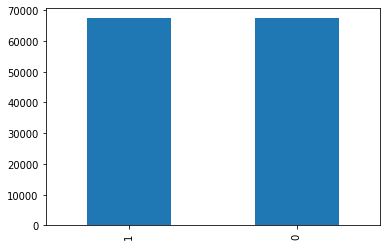

In [10]:
df['rating'].value_counts().plot.bar()

### Train Test Validation Split

#### Get Train Data

In [11]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.1, random_state=3)
for train_idx, test_idx in sss.split(df['review'], df['rating']):
    x_train, x_test = df['review'][train_idx], df['review'][test_idx]
    y_train, y_test = df['rating'][train_idx], df['rating'][test_idx]
    
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#### Get Test Data

In [12]:
sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.15, random_state=3)
for train_idx, val_idx in sss.split(x_train, y_train):
    idx_train = train_idx
    idx_val = val_idx

y_val = y_train[idx_val]
x_val = x_train[idx_val]
x_train_train = x_train[idx_train]
y_train_train = y_train[idx_train]
x_train = x_train_train
y_train = y_train_train

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

x_train

0         I met a lot of people who slept with my mother...
1         This is one of those games that clearly should...
2                          much funz. 10/10 would buy again
3         Got Franklin and Trevor spooked. They noclippe...
4         Less content than either Morrowind or Oblivion...
                                ...                        
103094    It suck that I can't remove this crepe from my...
103095    Pay for mods is something that EA would come u...
103096    Changed price to $79 right before summer sale,...
103097                    Great game to uninstall, 4/20 IGN
103098    why you no work?? Bought the disk, not the ste...
Name: review, Length: 103099, dtype: object

## NLP Preprocessing

### Tokenization and Removing Unnecessary Information

In [13]:
# Eksekusi preprocess untuk satu row data
def execute_preprocess(value):
    # Mendapatkan token seperti kata, tanda baca dari kalimat
    tokenList = word_tokenize(value)
    tokenList = [w.lower() for w in tokenList]

    # Menghilangkan stopwords dalam bahasa Inggris untuk mengurangi jumlah token yang diproses
    stop_words = set(stopwords.words('english'))
    tokenList = [word for word in tokenList if not word in stop_words]
    
    # Menggabungkan semua token menjadi 1 kalimat panjang dengan setiap token dipisahkan oleh spasi
    result = ""
    for token in tokenList:
        if token != "":
            result += token + ' '
    result = result[:-1]
    
    # Remove multiple space and tokens
    result = re.sub(r'[?=.*\!-_,\.]','',result)
    result = re.sub(' +', ' ', result)
    
    return result

# Preprocess setiap baris untuk setiap row dalam data
def preprocess_data(raw_data):
    tokens = []
    for raw in raw_data:
        tokenList = execute_preprocess(raw)
        tokens.append(tokenList)
    return tokens

In [14]:
x_train_prep = preprocess_data(x_train)
x_val_prep = preprocess_data(x_val)
x_test_prep = preprocess_data(x_test)

x_train_prep

['met lot people slept mother ',
 'one games clearly freeplay simply doesnt fit could awesome futuristic dungeon loot n shoot cooperative gamer fact endless grind designed put world constantly shown products like guns n toons could pull credit card go go buy wait years right ok go back packed another round see feel said could nice game nice reward system instead playing game makes like im deliberately incovenienced paying paying paying say thanks thanks',
 'much funz would buy',
 'got franklin trevor spooked noclipped plane fell later spookme',
 'less content either morrowind oblivion used able increase content mods ve nickled dimed away ',
 'pay game pay dlc pay mods re shill ',
 'play first levels boom thats game rush fast possible end skip mobs would reccommend gets boring hour ',
 'worth money',
 'one worst engines ever fps ',
 'ayo guys want play dis game time already got ghostly gibus rly happy look forward drop backburner going valve public order show rly skell da best game gabe

### Save and Load Prep File

In [15]:
save_prep_data()
x_train_prep, x_val_prep, x_test_prep, y_train, y_val, y_test = load_prep_data()
y_train

0         1
1         0
2         1
3         1
4         0
         ..
103094    0
103095    0
103096    0
103097    0
103098    0
Name: rating, Length: 103099, dtype: int64

### POS Tagging

In [16]:
from posTagger import posTagger

def split_string_to_list(string_list):
    splitted_strings = []
    for string_comp in string_list:
        splitted_strings.append(string_comp.split())
    return splitted_strings

def append_pos_tag(pos_tag_list):
    merge_pos_tag = []
    for i in range(len(pos_tag_list)):
        string_total = ""
        for j in range(len(pos_tag_list[i])):
            string_total += ' '
            string_total += pos_tag_list[i][j][0] + '_' + pos_tag_list[i][j][1].lower()
        merge_pos_tag.append(string_total[1:])
    return merge_pos_tag

In [17]:
x_train_prep_split =split_string_to_list(x_train_prep)
x_val_prep_split =split_string_to_list(x_val_prep)
x_test_prep_split =split_string_to_list(x_test_prep)

posTag = posTagger()
x_train_pos = posTag.pos_tag(x_train_prep_split)
x_val_pos = posTag.pos_tag(x_val_prep_split)
x_test_pos = posTag.pos_tag(x_test_prep_split)

print(len(x_train_pos), len(x_val_pos), len(x_test_pos))

103099 18194 13477


In [18]:
x_train_tagged = append_pos_tag(x_train_pos)
x_val_tagged = append_pos_tag(x_val_pos)
x_test_tagged = append_pos_tag(x_test_pos)
save_tagged_data()

In [19]:
x_train_tagged, x_val_tagged, x_test_tagged, y_train, y_val, y_test = load_tagged_data()
x_train_tagged

['met_verb lot_noun people_noun slept_verb mother_noun',
 'one_num games_noun clearly_adv freeplay_noun simply_adv doesnt_noun fit_noun could_verb awesome_adj futuristic_adj dungeon_noun loot_noun n_noun shoot_verb cooperative_adj gamer_noun fact_noun endless_adj grind_noun designed_verb put_verb world_noun constantly_adv shown_verb products_noun like_adp guns_noun n_noun toons_noun could_verb pull_verb credit_noun card_noun go_verb go_verb buy_verb wait_verb years_noun right_adv ok_adv go_verb back_adv packed_verb another_det round_noun see_verb feel_noun said_verb could_verb nice_adj game_noun nice_adj reward_noun system_noun instead_adv playing_verb game_noun makes_verb like_adp im_noun deliberately_adv incovenienced_verb paying_verb paying_verb paying_verb say_verb thanks_noun thanks_noun',
 'much_adj funz_noun would_verb buy_verb',
 'got_verb franklin_noun trevor_noun spooked_verb noclipped_noun plane_noun fell_verb later_adv spookme_noun',
 'less_adj content_noun either_conj morr

## Feature Extraction (TF-IDF)

### Fitting

In [20]:
tfidf = TfidfVectorizer(binary=True, use_idf = True, max_features=256)
tfidf = tfidf.fit(x_train_prep)
tfidf

TfidfVectorizer(binary=True, max_features=256)

### Extracting

In [21]:
x_train_tfidf = pd.DataFrame(tfidf.transform(x_train_prep).toarray(), columns=[tfidf.get_feature_names()])
x_val_tfidf = pd.DataFrame(tfidf.transform(x_val_prep).toarray(), columns=[tfidf.get_feature_names()])
x_test_tfidf = pd.DataFrame(tfidf.transform(x_test_prep).toarray(), columns=[tfidf.get_feature_names()])

save_tfidf_data()

x_train_tfidf

,able,actually,add,almost,already,also,always,amazing,amount,another,...,workshop,world,worst,worth,would,wrong,year,years,yes,yet
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.196611,...,0.0,0.193062,0.0,0.0,0.000000,0.0,0.0,0.193222,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.546392,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.406341,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103094,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
103095,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.287480,0.0,0.0,0.000000,0.0,0.0
103096,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.413857,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
103097,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


### Fitting Tagged

In [22]:
tfidf_tagged = TfidfVectorizer(binary=True, use_idf = True, max_features=256)
tfidf_tagged = tfidf_tagged.fit(x_train_tagged)
tfidf_tagged

TfidfVectorizer(binary=True, max_features=256)

### Extracting Tagged

In [23]:
x_train_tfidf_tagged = pd.DataFrame(tfidf_tagged.transform(x_train_tagged).toarray(), columns=[tfidf_tagged.get_feature_names()])
x_val_tfidf_tagged = pd.DataFrame(tfidf_tagged.transform(x_val_tagged).toarray(), columns=[tfidf_tagged.get_feature_names()])
x_test_tfidf_tagged = pd.DataFrame(tfidf_tagged.transform(x_test_tagged).toarray(), columns=[tfidf_tagged.get_feature_names()])

save_tfidf_tagged_data()

x_train_tfidf_tagged

,able_adj,actually_adv,almost_adv,already_adv,also_adv,always_adv,amazing_adj,amount_noun,another_det,anyone_noun,...,work_noun,workshop_noun,world_noun,worst_adj,worth_adj,would_verb,year_noun,years_noun,yes_adv,yet_adv
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.212606,0.0,...,0.00000,0.0,0.20717,0.0,0.0,0.000000,0.0,0.207473,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.522141,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,0.402425,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103094,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
103095,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.283612,0.0,0.000000,0.0,0.0
103096,0.000000,0.0,0.0,0.0,0.0,0.0,0.405788,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
103097,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0


## Classification 1: Support Vector Machine (SVM)

### Tanpa POS Tag

### Training

In [24]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train_tfidf[:50000], y_train[:50000])

SVC()

### Testing

In [25]:
y_test_predict = clf.predict(x_test_tfidf)
y_test_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [26]:
untagged_accuracy = accuracy_score(y_test, y_test_predict)
untagged_accuracy

0.9048007716850931

### Save Model

In [27]:
pickle.dump(clf, open(svm_file, 'wb'))

### Dengan POS Tag

### Training

In [28]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x_train_tfidf_tagged[:50000], y_train[:50000])

SVC()

### Testing

In [29]:
y_test_predict = clf.predict(x_test_tfidf_tagged)
y_test_predict

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [30]:
tagged_accuracy = accuracy_score(y_test, y_test_predict)
tagged_accuracy

0.8967871187949841

### Save Model

In [31]:
pickle.dump(clf, open(svm_pos_file, 'wb'))

## Classification 2: Deep Neural Network (DNN)

In [32]:
y_train_sigm = []
for y in y_train:
    if y == 1:
        y_train_sigm.append([0, 1])
    else:
        y_train_sigm.append([1, 0])
        
y_val_sigm = []
for y in y_val:
    if y == 1:
        y_val_sigm.append([0, 1])
    else:
        y_val_sigm.append([1, 0])

y_test_sigm = []
for y in y_test:
    if y == 1:
        y_test_sigm.append([0, 1])
    else:
        y_test_sigm.append([1, 0])

y_train_sigm = pd.DataFrame(y_train_sigm)
y_val_sigm = pd.DataFrame(y_val_sigm)
y_test_sigm = pd.DataFrame(y_test_sigm)

y_test_sigm

,0,1
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1
...,...,...
13472,1,0
13473,1,0
13474,0,1
13475,1,0


In [33]:
x_test_tfidf_tagged

,able_adj,actually_adv,almost_adv,already_adv,also_adv,always_adv,amazing_adj,amount_noun,another_det,anyone_noun,...,work_noun,workshop_noun,world_noun,worst_adj,worth_adj,would_verb,year_noun,years_noun,yes_adv,yet_adv
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
3,0.0,0.298208,0.0,0.000000,0.000000,0.300625,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.27434,0.208625,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13472,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
13473,0.0,0.000000,0.0,0.294957,0.239663,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.199654,0.0,0.0,0.000000,0.000000
13474,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000
13475,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000


### Model Building

In [34]:
dnn_model = Sequential()
dnn_model.add(keras.Input(shape=(256)))
dnn_model.add(Dense(64,activation='relu'))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(8,activation='relu'))
dnn_model.add(Dropout(0.1))
dnn_model.add(Dense(1,activation='sigmoid'))
dnn_model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.01),metrics=['accuracy'])
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 520       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 16,977
Trainable params: 16,977
Non-trainable params: 0
_________________________________________________________________


### Training

In [35]:
history = dnn_model.fit(x_train_tfidf_tagged[:50000], y_train[:50000], validation_data=(x_val_tfidf_tagged[:5000], y_val[:5000]), \
                    epochs = epoch_count_dnn_1, batch_size = 64)

Epoch 1/50
782/782 [==============================] - 1s 2ms/step - loss: 0.1356 - accuracy: 0.8053 - val_loss: 0.1259 - val_accuracy: 0.8234
Epoch 2/50
782/782 [==============================] - 1s 2ms/step - loss: 0.1166 - accuracy: 0.8377 - val_loss: 0.1168 - val_accuracy: 0.8386
Epoch 3/50
782/782 [==============================] - 1s 2ms/step - loss: 0.1035 - accuracy: 0.8600 - val_loss: 0.1085 - val_accuracy: 0.8542
Epoch 4/50
782/782 [==============================] - 1s 2ms/step - loss: 0.0946 - accuracy: 0.8721 - val_loss: 0.1076 - val_accuracy: 0.8590
Epoch 5/50
782/782 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.8822 - val_loss: 0.0989 - val_accuracy: 0.8740
Epoch 6/50
782/782 [==============================] - 1s 2ms/step - loss: 0.0832 - accuracy: 0.8899 - val_loss: 0.0977 - val_accuracy: 0.8736
Epoch 7/50
782/782 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.8930 - val_loss: 0.0960 - val_accuracy: 0.8750
Epoch 

### Testing

In [36]:
y_pred=(dnn_model.predict(x_test_tfidf_tagged))
for y in y_pred:
    y[0] = round(y[0])
y_pred = y_pred.astype("int32")
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

### Accuracy

In [37]:
dnn_accuracy = accuracy_score(y_test, y_pred)
dnn_accuracy

0.899013133486681

### Save Model

In [38]:
dnn_model.save(dnn_file)

## Classification 3: Long-Short Term Memory (LSTM)

### Word To Vec

In [39]:
tokenizer = Tokenizer(num_words = unique_word_len, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, oov_token='<<OOV>>')
tokenizer.fit_on_texts(x_train_tagged)

x_train_lstm = tokenizer.texts_to_sequences(x_train_tagged)
x_val_lstm = tokenizer.texts_to_sequences(x_val_tagged)
x_test_lstm = tokenizer.texts_to_sequences(x_test_tagged)

x_train_lstm

[[1, 3, 88, 2, 22, 2, 1, 3, 1, 2],
 [16,
  15,
  25,
  2,
  1,
  5,
  1,
  2,
  292,
  5,
  1,
  2,
  1,
  2,
  55,
  3,
  136,
  4,
  1,
  4,
  1,
  2,
  1,
  2,
  1,
  2,
  344,
  3,
  1,
  4,
  1,
  2,
  254,
  2,
  1,
  4,
  277,
  2,
  1,
  3,
  123,
  3,
  114,
  2,
  464,
  5,
  1,
  3,
  1,
  2,
  14,
  7,
  354,
  2,
  1,
  2,
  1,
  2,
  55,
  3,
  1,
  3,
  1,
  2,
  244,
  2,
  41,
  3,
  41,
  3,
  24,
  3,
  177,
  3,
  133,
  2,
  111,
  5,
  407,
  5,
  41,
  3,
  75,
  5,
  1,
  3,
  139,
  28,
  1,
  2,
  91,
  3,
  148,
  2,
  181,
  3,
  55,
  3,
  150,
  4,
  6,
  2,
  150,
  4,
  1,
  2,
  110,
  2,
  195,
  5,
  32,
  3,
  6,
  2,
  140,
  3,
  14,
  7,
  230,
  2,
  1,
  5,
  1,
  3,
  268,
  3,
  268,
  3,
  268,
  3,
  70,
  3,
  287,
  2,
  287,
  2],
 [34, 4, 1, 2, 19, 3, 24, 3],
 [64, 3, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 3, 398, 5, 1, 2],
 [335,
  4,
  119,
  2,
  242,
  179,
  1,
  4,
  1,
  2,
  173,
  3,
  191,
  4,
  1,
  3,
  119,
  2,
  12,
  2,
  58,


### Padding

In [40]:
x_train_padded = pad_sequences(x_train_lstm, maxlen = sentence_len, padding="pre", truncating="post")
x_val_padded = pad_sequences(x_val_lstm, maxlen = sentence_len, padding="pre", truncating="post")
x_test_padded = pad_sequences(x_test_lstm, maxlen = sentence_len, padding="pre", truncating="post")

x_train_padded

array([[  0,   0,   0, ...,   3,   1,   2],
       [ 16,  15,  25, ...,   3,   1,   2],
       [  0,   0,   0, ...,   3,  24,   3],
       ...,
       [  0,   0,   0, ...,   3, 100,   4],
       [  0,   0,   0, ...,   2,   1,   2],
       [  0,   0,   0, ...,   7, 120,   4]])

### Building Model

In [41]:
model = Sequential()
model.add(Embedding(input_dim = unique_word_len, output_dim = embedding_size, input_length = sentence_len))
model.add(LSTM(128, dropout = dropout, recurrent_dropout = dropout))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.01),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 256)           128000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 325,249
Trainable params: 325,249
Non-trainable params: 0
_________________________________________________________________


### Training

In [42]:
history = model.fit(x_train_padded[:50000], y_train[:50000], validation_data=(x_val_padded[:5000], y_val[:5000]), \
                    epochs = epoch_count_dnn_2, batch_size = 64)

Epoch 1/10
782/782 [==============================] - 159s 204ms/step - loss: 0.1331 - accuracy: 0.8101 - val_loss: 0.1209 - val_accuracy: 0.8320
Epoch 2/10
782/782 [==============================] - 159s 203ms/step - loss: 0.1164 - accuracy: 0.8352 - val_loss: 0.1154 - val_accuracy: 0.8408
Epoch 3/10
782/782 [==============================] - 159s 203ms/step - loss: 0.1168 - accuracy: 0.8360 - val_loss: 0.1236 - val_accuracy: 0.8272
Epoch 4/10
782/782 [==============================] - 158s 202ms/step - loss: 0.1170 - accuracy: 0.8361 - val_loss: 0.1209 - val_accuracy: 0.8290
Epoch 5/10
782/782 [==============================] - 157s 201ms/step - loss: 0.1166 - accuracy: 0.8371 - val_loss: 0.1197 - val_accuracy: 0.8328
Epoch 6/10
782/782 [==============================] - 157s 201ms/step - loss: 0.1165 - accuracy: 0.8376 - val_loss: 0.1200 - val_accuracy: 0.8400
Epoch 7/10
782/782 [==============================] - 156s 200ms/step - loss: 0.1175 - accuracy: 0.8360 - val_loss: 0.1209 -

### Testing

In [43]:
y_pred=(model.predict(x_test_padded))
for y in y_pred:
    y[0] = round(y[0])
y_pred = y_pred.astype("int32")
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

### Accuracy

In [44]:
lstm_accuracy = accuracy_score(y_test, y_pred)
lstm_accuracy

0.8357943162424872

### Save Model

In [45]:
model.save(lstm_file)